In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from math import sqrt

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1552\1042289312.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*************         28%                       ]  7 of 25 completed

[*********************100%***********************]  25 of 25 completed


✅ Retrieved 25 assets over 500 days

🔹 Processing Standard Estimator...
   Saved heatmap: global_standard_cov.png
   Average Standard Frobenius Distance: 10.1677

🔹 Processing Glasso (Alpha=0.1)...
   Saved heatmap: global_glasso_cov_alpha_0.1.png
   Saved heatmap: global_glasso_precision_alpha_0.1.png


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\covariance\_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.231e-04
  warnings.warn(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\covariance\_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -4.321e-04
  warnings.warn(


   Average Frobenius Distance for Alpha=0.1: 4.1096

🔹 Processing Glasso (Alpha=0.3)...
   Saved heatmap: global_glasso_cov_alpha_0.3.png
   Saved heatmap: global_glasso_precision_alpha_0.3.png
   Average Frobenius Distance for Alpha=0.3: 1.9868

🔹 Processing Glasso (Alpha=0.4)...
   Saved heatmap: global_glasso_cov_alpha_0.4.png
   Saved heatmap: global_glasso_precision_alpha_0.4.png
   Average Frobenius Distance for Alpha=0.4: 1.1928

🔹 Processing Glasso (Alpha=0.5)...
   Saved heatmap: global_glasso_cov_alpha_0.5.png
   Saved heatmap: global_glasso_precision_alpha_0.5.png
   Average Frobenius Distance for Alpha=0.5: 0.5954

🔹 Processing Glasso (Alpha=0.6)...
   Saved heatmap: global_glasso_cov_alpha_0.6.png
   Saved heatmap: global_glasso_precision_alpha_0.6.png
   Average Frobenius Distance for Alpha=0.6: 0.2116

🔹 Processing Glasso (Alpha=0.7)...
   Saved heatmap: global_glasso_cov_alpha_0.7.png
   Saved heatmap: global_glasso_precision_alpha_0.7.png
   Average Frobenius Distance 

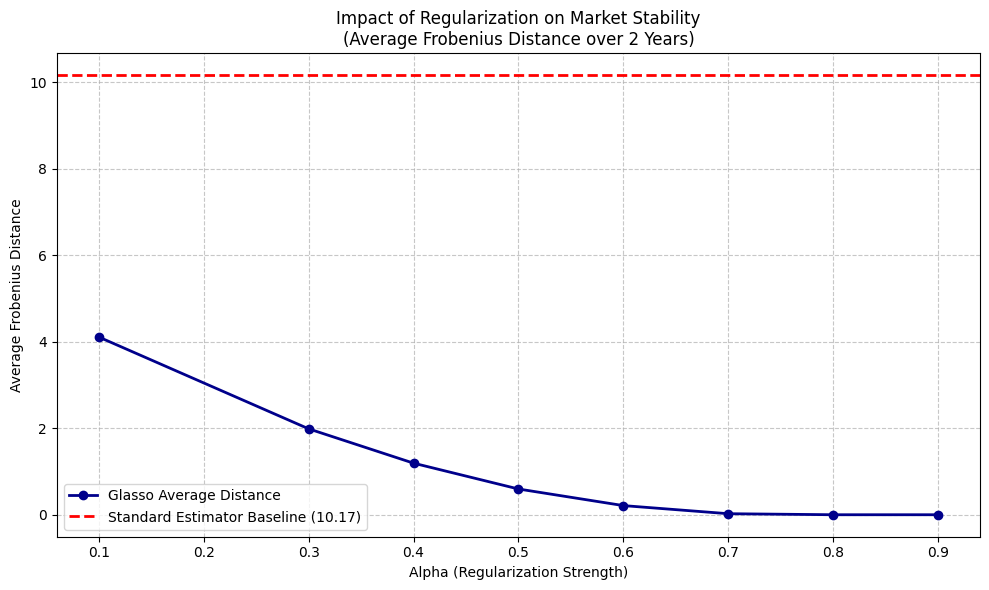

✅ Saved summary plot: average_distance_vs_alpha.png
✅ All analyses complete.


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import ledoit_wolf, graphical_lasso
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. ESTIMATOR FUNCTIONS ---

def compute_glasso(returns, alpha):
    """
    Computes Glasso Covariance AND Precision Matrix.
    """
    try:
        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(returns)
        
        # Ledoit-Wolf (Robust initialization)
        emp_cov, _ = ledoit_wolf(X_scaled, assume_centered=True)
        
        # Graphical Lasso
        cov_matrix, prec_matrix = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
        return cov_matrix, prec_matrix
    except Exception as e:
        print(f"Error computing Glasso: {e}")
        return None, None

def compute_standard_cov(returns):
    """
    Computes Standard Empirical Covariance Matrix.
    """
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(returns)
        cov_matrix = np.cov(X_scaled.T, bias=True) 
        return cov_matrix
    except Exception as e:
        print(f"Error computing Standard Cov: {e}")
        return None

# --- 2. DATA RETRIEVAL ---
def get_data(tickers, start_date, end_date):
    print("Downloading data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    returns = data.pct_change().dropna(how="any")
    print(f"✅ Retrieved {returns.shape[1]} assets over {returns.shape[0]} days")
    return returns

# --- 3. PLOTTING HELPER ---
def plot_heatmap(matrix, labels, title, filename):
    plt.figure(figsize=(12, 10))
    sns.heatmap(pd.DataFrame(matrix, index=labels, columns=labels), 
                cmap='coolwarm', center=0, square=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"   Saved heatmap: {filename}")

# --- 4. ROLLING ANALYSIS RUNNER ---
def run_rolling_analysis(returns_df, method, window_size, alpha=None):
    # print(f"\n--- Running Rolling Analysis: Method = {method} (Alpha={alpha}) ---")
    
    distances = []
    dates = []
    prev_cov = None
    
    num_windows = len(returns_df) // window_size
    
    # Create directory for CSVs
    output_dir = f"covariance_matrices_{method}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        
        window_data = returns_df.iloc[start_idx:end_idx]
        current_date = window_data.index[-1].date()
        date_str = str(current_date)
        
        current_cov = None
        
        # Compute Covariance
        if method == "Glasso":
            current_cov, _ = compute_glasso(window_data, alpha)
            filename_prefix = f"alpha={alpha}_glasso_cov"
        else: # Standard
            current_cov = compute_standard_cov(window_data)
            filename_prefix = "standard_estimator_cov"

        if current_cov is not None:
            # Save CSV
            filename = f"{output_dir}/{filename_prefix}_{date_str}.csv"
            cov_df = pd.DataFrame(current_cov, index=window_data.columns, columns=window_data.columns)
            cov_df.to_csv(filename)

            # Calculate Distance (Frobenius Norm of Covariance change)
            if prev_cov is not None:
                diff = current_cov - prev_cov
                dist = np.linalg.norm(diff, ord='fro')
                distances.append(dist)
                dates.append(current_date)
            
            prev_cov = current_cov
            
    return dates, distances

# --- 5. MAIN EXECUTION ---
if __name__ == "__main__":
    # CONFIGURATION
    TICKERS = [
        "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "META",
        "JPM", "BAC", "V", "MA", "GS",
        "JNJ", "PFE", "UNH", "LLY",
        "PG", "KO", "PEP", "WMT", "COST",
        "XOM", "CVX", "BA", "CAT" 
    ]
    START_DATE = "2022-01-01"
    END_DATE = "2024-01-01"
    T = [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] 
    WINDOW_WEEKS = 2
    TRADING_DAYS_PER_WEEK = 5
    WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK 
    
    # 1. Get Data
    returns_df = get_data(TICKERS, START_DATE, END_DATE)
    tickers = returns_df.columns

    # 2. GLOBAL STANDARD COVARIANCE (Calculated once)
    print("\n🔹 Processing Standard Estimator...")
    # A. Global Plot
    global_std_cov = compute_standard_cov(returns_df)
    plot_heatmap(global_std_cov, tickers, 
                 "Global Standard Covariance Matrix (Full Dataset)", 
                 "global_standard_cov.png")
    
    # B. Rolling Analysis (Standard)
    s_dates, s_dists = run_rolling_analysis(returns_df, "Standard", WINDOW_SIZE)
    # Calculate average distance for Standard Estimator (Baseline)
    avg_std_dist = np.mean(s_dists) if s_dists else 0
    print(f"   Average Standard Frobenius Distance: {avg_std_dist:.4f}")

    # 3. LOOP OVER ALPHAS (GLASSO)
    avg_glasso_dists = [] # List to store average distance for each alpha

    for ALPHA in T:
        print(f"\n🔹 Processing Glasso (Alpha={ALPHA})...")
        
        # A. Global Plots
        global_cov, global_prec = compute_glasso(returns_df, ALPHA)
        
        if global_cov is not None:
            # Plot Covariance
            plot_heatmap(global_cov, tickers, 
                         f"Global Glasso Covariance Matrix (Alpha={ALPHA})", 
                         f"global_glasso_cov_alpha_{ALPHA}.png")
            # Plot Precision
            plot_heatmap(global_prec, tickers, 
                         f"Global Glasso Precision Matrix (Alpha={ALPHA})", 
                         f"global_glasso_precision_alpha_{ALPHA}.png")
        
        # B. Rolling Analysis
        g_dates, g_dists = run_rolling_analysis(returns_df, "Glasso", WINDOW_SIZE, ALPHA)
        
        # C. Calculate Average Distance for this Alpha
        if len(g_dists) > 0:
            avg_dist = np.mean(g_dists)
            avg_glasso_dists.append(avg_dist)
            print(f"   Average Frobenius Distance for Alpha={ALPHA}: {avg_dist:.4f}")
        else:
            avg_glasso_dists.append(0)

        # D. Plot Comparison (Rolling Comparison)
        plt.figure(figsize=(14, 7))
        plt.plot(g_dates, g_dists, marker='o', label=f'Glasso (Alpha={ALPHA})', color='blue', alpha=0.7)
        plt.plot(s_dates, s_dists, marker='x', label='Standard Estimator', color='red', alpha=0.7, linestyle='--')
        
        plt.title(f'Frobenius Distance Comparison (Alpha={ALPHA})\nWindow: {WINDOW_WEEKS} Weeks')
        plt.xlabel('Date')
        plt.ylabel('Frobenius Distance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        plot_filename = f'comparison_plot_alpha_{ALPHA}.png'
        plt.savefig(plot_filename)
        plt.close()

    # 4. FINAL PLOT: AVERAGE DISTANCE VS ALPHA
    print("\n🔹 Generating Summary Plot: Average Distance vs Alpha...")
    plt.figure(figsize=(10, 6))
    
    # Plot Glasso Curve
    plt.plot(T, avg_glasso_dists, marker='o', linestyle='-', linewidth=2, color='darkblue', label='Glasso Average Distance')
    
    # Plot Standard Estimator Baseline (Horizontal Line)
    plt.axhline(y=avg_std_dist, color='red', linestyle='--', linewidth=2, label=f'Standard Estimator Baseline ({avg_std_dist:.2f})')
    
    plt.title('Impact of Regularization on Market Stability\n(Average Frobenius Distance over 2 Years)')
    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Average Frobenius Distance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    summary_filename = 'average_distance_vs_alpha.png'
    plt.savefig(summary_filename)
    plt.show()
    
    print(f"✅ Saved summary plot: {summary_filename}")
    print("✅ All analyses complete.")

In [8]:
df = pd.read_csv("cleaned_assets_price_volume_data_6_months_no_std.csv")
df.head()


,Date,Open,High,Low,Close,Ticker
0,2024-09-12,2722.137939,2734.683105,2716.554932,2717.123047,000001.SS
1,2024-09-13,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS
2,2024-09-14,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS
3,2024-09-15,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS
4,2024-09-16,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS


In [9]:
prices = df.pivot(index="Date", columns="Ticker", values="Close").sort_index()

# Compute daily log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Standardize the returns
scaler = StandardScaler()
X = scaler.fit_transform(returns.values)
X = torch.tensor(X, dtype=torch.float32)

n_assets = returns.shape[1]
print(f"Using {n_assets} assets over {len(returns)} days")
print(returns)

Using 643 assets over 178 days
Ticker      000001.SS   0001.HK   0002.HK   0011.HK   0019.HK   0083.HK  \
Date                                                                      
2024-09-13  -0.004808  0.009382  0.004307  0.010565  0.025318  0.001267   
2024-09-14   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2024-09-15   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2024-09-16   0.000000  0.008388  0.008559 -0.002769  0.004024  0.017566   
2024-09-17   0.000000  0.022420  0.008487  0.026274  0.000000  0.016040   
...               ...       ...       ...       ...       ...       ...   
2025-03-08   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2025-03-09   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2025-03-10  -0.001894  0.002018 -0.003899  0.012065  0.044831 -0.007576   
2025-03-11   0.004051  0.007032  0.003899 -0.002771  0.018615  0.011561   
2025-03-12  -0.002341 -0.012085 -0.007813 -0.010228  0.000000  0.0012

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [ ]:
prices = df.pivot(index="Date", columns="Ticker", values="Close").sort_index()

# Compute daily log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Standardize the returns
scaler = StandardScaler()
X = scaler.fit_transform(returns.values)
X = torch.tensor(X, dtype=torch.float32)

n_assets = returns.shape[1]
print(f"Using {n_assets} assets over {len(returns)} days")
print(returns)
# --- IMPORTS ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import ledoit_wolf, graphical_lasso
import os

# --- LOAD DATA ---
X = pd.read_csv("cleaned_assets_price_volume_data_6_months_no_std.csv").dropna()
assetss = X['Ticker'].unique()
print(len(assetss))
print("Using dataset with", len(assetss), "assets")

# --- PREPROCESS ---
X['Date'] = pd.to_datetime(X['Date'])

# Pivot to form a matrix of Close prices (Date × Ticker)
price_df = X.pivot(index='Date', columns='Ticker', values='Close')

returns = price_df.pct_change().dropna(how="any")   # pct_change do [p(t)-p(t-1)]/p(t-1)
                # drop any day with missing data
print(f"✅ Using {returns.shape[1]} assets over {returns.shape[0]} days")

# --- STANDARDIZE ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(returns)
print("X_scaled shape:", X_scaled.shape)

# --- COMPUTE EMPIRICAL COVARIANCE ---
emp_cov, _ = ledoit_wolf(X_scaled, assume_centered=True)

# --- GRAPHICAL LASSO ---
alpha = 0.4# higher = more sparsity
cov_matrix, prec_matrix = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
print("Covariance matrix shape:", cov_matrix.shape)

# --- IDENTIFY UNCORRELATED TICKERS ---
threshold = 1e8  # treat very small values as 0
cov_abs = np.abs(cov_matrix)
np.fill_diagonal(cov_abs, 0)  # ignore self-covariance

uncorrelated_mask = (cov_abs < threshold).all(axis=1)
uncorrelated_tickers = returns.columns[uncorrelated_mask].tolist()

print(f"✅ Found {len(uncorrelated_tickers)} uncorrelated tickers (|cov| < {threshold})")

# --- FILTER ORIGINAL DATA ---
X_uncorr = X[X['Ticker'].isin(uncorrelated_tickers)]

# --- SAVE NEW FILTERED DATABASE ---
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
output_file = os.path.join(desktop_path, "uncorrelated_tickers_dataset.csv")
X_uncorr.to_csv(output_file, index=False, encoding='utf-8-sig')
ov_df = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
prec_df = pd.DataFrame(prec_matrix, index=tickers, columns=tickers)

cov_df.to_csv("covariance_using_return_alpha=0.2.csv")
prec_df.to_csv("precision_using_return_alpha=0.2.csv")
assets = pd.read_csv(output_file)['Ticker'].unique()
print(len(assets))
print(f"✅ Saved new dataset with uncorrelated tickers to:\n{output_file}")
print(cov_matrix)


In [ ]:
# --- IMPORTS ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import ledoit_wolf, graphical_lasso
import os

# --- LOAD DATA ---
X = pd.read_csv("cleaned_assets_price_volume_data_6_months_no_std.csv").dropna()
assetss = X['Ticker'].unique()
print(len(assetss))
print("Using dataset with", len(assetss), "assets")

# --- PREPROCESS ---
X['Date'] = pd.to_datetime(X['Date'])

# Pivot to form a matrix of Close prices (Date × Ticker)
price_df = X.pivot(index='Date', columns='Ticker', values='Close')

returns = price_df.pct_change().dropna(how="any")   # pct_change do [p(t)-p(t-1)]/p(t-1)
                # drop any day with missing data
print(f"✅ Using {returns.shape[1]} assets over {returns.shape[0]} days")

# --- STANDARDIZE ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(returns)
print("X_scaled shape:", X_scaled.shape)

# --- COMPUTE EMPIRICAL COVARIANCE ---
emp_cov, _ = ledoit_wolf(X_scaled, assume_centered=True)

# --- GRAPHICAL LASSO ---
alpha = 0.4# higher = more sparsity
cov_matrix, prec_matrix = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
print("Covariance matrix shape:", cov_matrix.shape)

# --- IDENTIFY UNCORRELATED TICKERS ---
threshold = 1e8  # treat very small values as 0
cov_abs = np.abs(cov_matrix)
np.fill_diagonal(cov_abs, 0)  # ignore self-covariance

uncorrelated_mask = (cov_abs < threshold).all(axis=1)
uncorrelated_tickers = returns.columns[uncorrelated_mask].tolist()

print(f"✅ Found {len(uncorrelated_tickers)} uncorrelated tickers (|cov| < {threshold})")

# --- FILTER ORIGINAL DATA ---
X_uncorr = X[X['Ticker'].isin(uncorrelated_tickers)]

# --- SAVE NEW FILTERED DATABASE ---
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
output_file = os.path.join(desktop_path, "uncorrelated_tickers_dataset.csv")
X_uncorr.to_csv(output_file, index=False, encoding='utf-8-sig')
cov_df = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
prec_df = pd.DataFrame(prec_matrix, index=tickers, columns=tickers)

cov_df.to_csv("covariance_using_return_alpha=0.2.csv")
prec_df.to_csv("precision_using_return_alpha=0.2.csv")
assets = pd.read_csv(output_file)['Ticker'].unique()
print(len(assets))
print(f"✅ Saved new dataset with uncorrelated tickers to:\n{output_file}")
print(cov_matrix)


643
Using dataset with 643 assets
✅ Using 643 assets over 181 days
X_scaled shape: (181, 643)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Covariance matrix shape: (643, 643)
✅ Found 643 uncorrelated tickers (|cov| < 100000000.0)


NameError: name 'tickers' is not defined

Computed Scalars:
 A=41424.26, B=-11.90, C=0.0351, D=1312.32


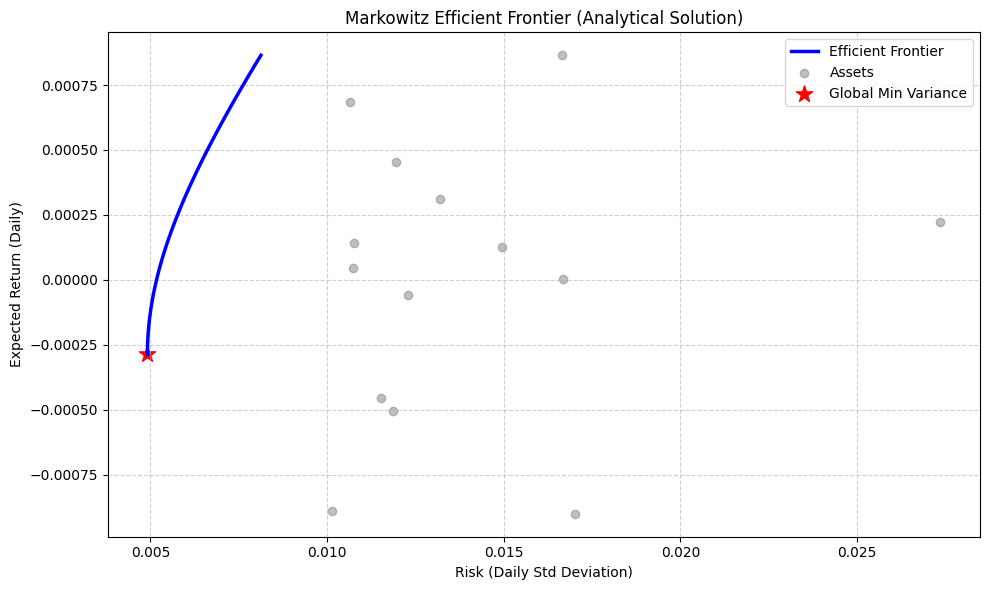

✅ Markowitz Optimization Complete. Plot saved.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. LOAD & PREPARE DATA ---
# Load your dataset
df = pd.read_csv('cleaned_assets_price_volume_data_6_months_no_std.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Define Tickers (Using the subset of 25 for stability)
TICKERS = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "META",
    "JPM", "BAC", "V", "MA", "GS",
    "JNJ", "PFE", "UNH", "LLY",
    "PG", "KO", "PEP", "WMT", "COST",
    "XOM", "CVX", "BA", "CAT" 
]

# Create Returns Matrix
df_subset = df[df['Ticker'].isin(TICKERS)].copy()
price_df = df_subset.pivot(index='Date', columns='Ticker', values='Close')
returns_df = price_df.pct_change().dropna(how="any")

# --- 2. MARKOWITZ FORMULAS (From PDF) ---
# Inputs
mu = returns_df.mean()  # Vector of expected returns
Sigma = returns_df.cov() # Covariance matrix

# Invert Covariance Matrix
# We use pseudo-inverse to handle potential stability issues, though inv() usually works for T > N
Sigma_inv = np.linalg.pinv(Sigma.values)

# Calculate Scalars A, B, C, D
ones = np.ones(len(mu))
A = ones.T @ Sigma_inv @ ones
B = ones.T @ Sigma_inv @ mu.values
C = mu.values.T @ Sigma_inv @ mu.values
D = A*C - B**2

print(f"Computed Scalars:\n A={A:.2f}, B={B:.2f}, C={C:.4f}, D={D:.2f}")

# --- 3. EFFICIENT FRONTIER ---
# Define range of target returns (p)
# Start from the Global Min Var return (p_min = B/A) and go up
p_min = B / A
sigma_min = np.sqrt(1/A)

target_returns = np.linspace(p_min, mu.max(), 100)
frontier_risks = []

for p in target_returns:
    # Variance formula: sigma^2 = (A*p^2 - 2*B*p + C) / D
    variance = (A * p**2 - 2*B * p + C) / D
    frontier_risks.append(np.sqrt(variance))

# --- 4. PLOT ---
plt.figure(figsize=(10, 6))

# Efficient Frontier Line
plt.plot(frontier_risks, target_returns, 'b-', linewidth=2.5, label='Efficient Frontier')

# Individual Assets
asset_risks = np.sqrt(np.diag(Sigma))
plt.scatter(asset_risks, mu.values, c='gray', alpha=0.5, label='Assets')

# Global Minimum Variance Portfolio
plt.scatter(sigma_min, p_min, c='red', s=150, marker='*', label='Global Min Variance')

plt.title('Markowitz Efficient Frontier (Analytical Solution)')
plt.xlabel('Risk (Daily Std Deviation)')
plt.ylabel('Expected Return (Daily)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('markowitz_analytical_frontier.png')
plt.show()

print("✅ Markowitz Optimization Complete. Plot saved.")


✅ Tangency Portfolio Stats:
Expected Return: 0.317408
Volatility: 1.620775
Loaded shape: (117026, 6)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11408\3796284522.py:43: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(price_path, parse_dates=True, infer_datetime_format=True)


,Date,Open,High,Low,Close,Ticker
0,2024-09-12,2722.137939,2734.683105,2716.554932,2717.123047,000001.SS
1,2024-09-13,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS
2,2024-09-14,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS
3,2024-09-15,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS
4,2024-09-16,2718.986084,2728.780029,2703.368896,2704.090088,000001.SS


Detected price columns: 4
Columns used for prices: 4
Assets used: 4
Tangency port return (per period): 0.11990031836821329 vol: 14.3774775854887 Sharpe: 0.008331295523999062
Saved PDF report to: efficient_frontier_report.pdf


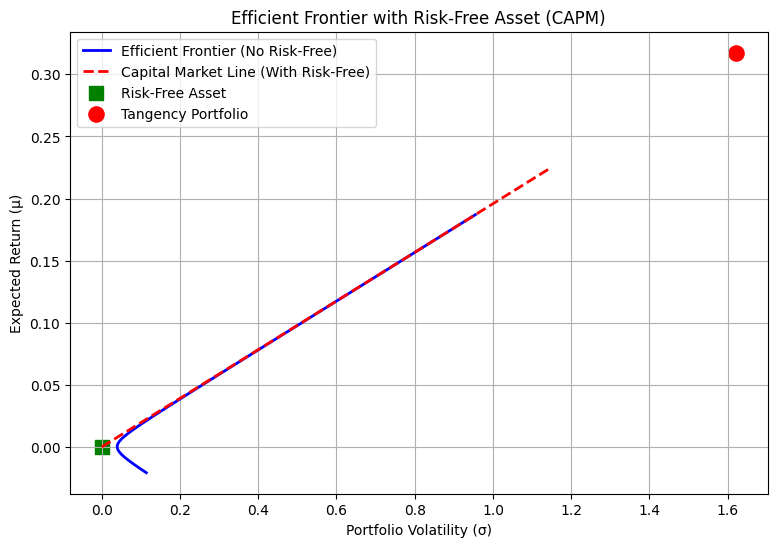

In [ ]:
# ==============================================================
#      EFFICIENT FRONTIER WITH RISK-FREE ASSET (CML)
# ==============================================================

# --- Risk-free rate (2% annualized) ---
rf = 0.04/ 252   # daily risk-free rate

# --- Tangency portfolio (from CAPM theory) ---
excess_mu = mu - rf * ones
w_tangent = Sigma_inv @ excess_mu
w_tangent = w_tangent / np.sum(w_tangent)

# --- Tangency portfolio return & volatility ---
mu_m = w_tangent @ mu
sigma_m = np.sqrt(w_tangent.T @ cov_matrix @ w_tangent)

print("\n✅ Tangency Portfolio Stats:")
print(f"Expected Return: {mu_m:.6f}")
print(f"Volatility: {sigma_m:.6f}")

# --- Capital Market Line (CML) ---
sigma_cml = np.linspace(0, max(sigma_min)*1.2, 100)
mu_cml = rf + ((mu_m - rf) / sigma_m) * sigma_cml

# --- PLOT ---
plt.figure(figsize=(9,6))

# Old frontier (risky only)
plt.plot(sigma_min, p_values, 'b-', lw=2, label="Efficient Frontier (No Risk-Free)")

# Capital Market Line
plt.plot(sigma_cml, mu_cml, 'r--', lw=2, label="Capital Market Line (With Risk-Free)")

# Risk-free point
plt.scatter(0, rf, c='green', s=100, marker='s', label="Risk-Free Asset")

# Tangency (market) portfolio
plt.scatter(sigma_m, mu_m, c='red', s=120, marker='o', label="Tangency Portfolio")

plt.xlabel("Portfolio Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier with Risk-Free Asset (CAPM)")
plt.legend()
plt.grid(True)
plt.show()
